In [39]:
import pandas as pd
from functools import partialmethod
pd.DataFrame.head = partialmethod(pd.DataFrame.head, n=2)
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
from functions import *
from scipy.stats import stats, norm
from statsmodels.formula.api import ols
from fancyimpute import KNN
from sklearn import preprocessing
from sklearn.feature_extraction import FeatureHasher
from collections import Counter
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier, plot_importance
from matplotlib.pyplot import figure
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, auc, roc_auc_score, plot_roc_curve, classification_report
import joblib
from functools import partial

# 1. Data Preparation

In [40]:
pd.set_option('display.max_columns', None)
df1 = pd.read_csv('ml_case_training_data.csv')
df2 = pd.read_csv('ml_case_training_hist_data.csv')
df3 = pd.read_csv('ml_case_training_output.csv')
df2 = df2.merge(df3, how='inner', on='id')
df2.head()

,id,price_date,price_p1_var,price_p2_var,price_p3_var,price_p1_fix,price_p2_fix,price_p3_fix,churn
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0,0
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0,0


There are duplicated rows for price file. <br>
We have to decide how to treat the duplicates and make them in one rows. <br>

## See the time series of prices by churn

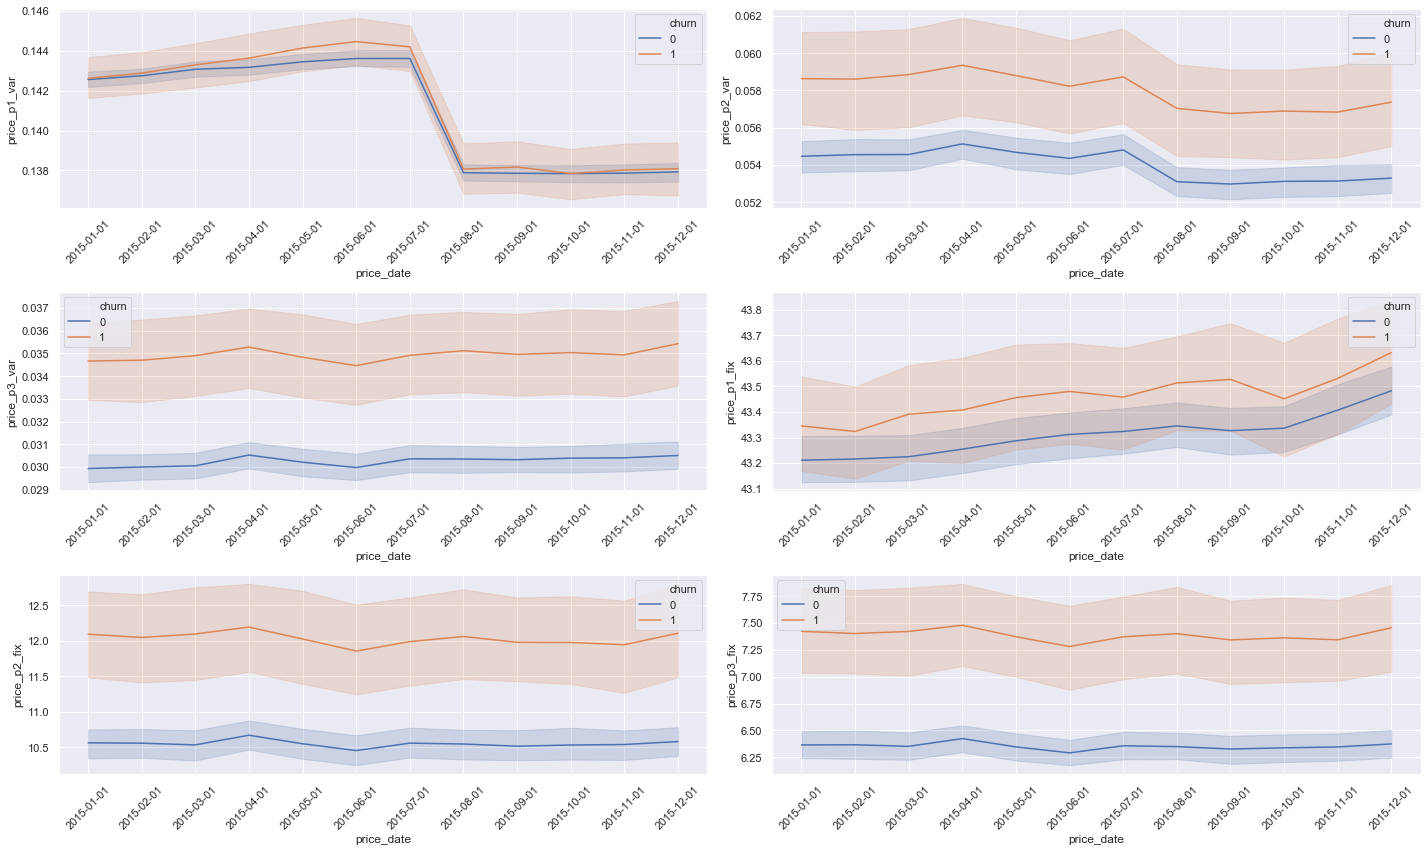

In [41]:
sns.set(style="darkgrid")
fig, ax = plt.subplots(3,2, figsize=(20, 12))
plt.subplot(3,2,1)
sns.lineplot(x="price_date", y="price_p1_var", hue="churn",data=df2)
plt.xticks(rotation=45)
plt.subplot(3,2,2)
sns.lineplot(x="price_date", y="price_p2_var",hue="churn",data=df2)
plt.xticks(rotation=45)
plt.subplot(3,2,3)
sns.lineplot(x="price_date", y="price_p3_var",hue="churn",data=df2)
plt.xticks(rotation=45)
plt.subplot(3,2,4)
sns.lineplot(x="price_date", y="price_p1_fix",hue="churn",data=df2)
plt.xticks(rotation=45)
plt.subplot(3,2,5)
sns.lineplot(x="price_date", y="price_p2_fix",hue="churn",data=df2)
plt.xticks(rotation=45)
plt.subplot(3,2,6)
sns.lineplot(x="price_date", y="price_p3_fix",hue="churn",data=df2)
plt.xticks(rotation=45)

plt.tight_layout()

- Generally customers who have churned paid higher prices whatever the season.<br>
- There is string time series in 'price_p1_var' and the value for churn and non-churn is similar.<br>
- Thus, it is better that to drop 'price_p1_var' and transform the monthly pricing data to yearly, by taking the average.

In [42]:
# Drop 'price_p1_var'
# Group by 'id' and take average of prices
df2.drop(['price_date', 'price_p1_var'],inplace=True,axis=1)
df2 = df2.groupby(['id'], as_index=False).mean()
df = df1.merge(df2, how='inner', on='id')
df.head()

,id,activity_new,campaign_disc_ele,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_first_activ,date_modif_prod,date_renewal,forecast_base_bill_ele,forecast_base_bill_year,forecast_bill_12m,forecast_cons,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_p1,forecast_price_energy_p2,forecast_price_pow_p1,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,price_p2_var,price_p3_var,price_p1_fix,price_p2_fix,price_p3_fix,churn
0,48ada52261e7cf58715202705a0451c9,esoiiifxdlbkcsluxmfuacbdckommixw,NaN,lmkebamcaaclubfxadlmueccxoimlema,309275,0,10025,2012-11-07,2016-11-06,NaN,2012-11-07,2015-11-09,NaN,NaN,NaN,NaN,26520.3,10025,0.0,359.29,0.095919,0.088347,58.995952,f,831.8,-41.76,-41.76,1,1732.36,3,ldkssxwpmemidmecebumciepifcamkci,180.000,0.092115,0.067241,58.956502,36.356887,8.337051,0
1,24011ae4ebbe3035111d65fa7c15bc57,NaN,NaN,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,NaN,NaN,2015-06-23,NaN,NaN,NaN,NaN,0.0,0,0.0,1.78,0.114481,0.098142,40.606701,t,0.0,25.44,25.44,2,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,0.102137,0.072579,40.640023,24.384011,16.256008,1


In [43]:
# check duplicated rows
quant_dup(df2['id'])

0

In [44]:
table1 = []
for col in df.columns:
    table1.append((col, df[col].nunique(), df[col].isnull().sum(),  df[col].dtype))
    
table1_df = pd.DataFrame(table1, columns=['Variable Name', 'Unique Value', 'Missing Value', 'Data Type'])
table1_df

,Variable Name,Unique Value,Missing Value,Data Type
0,id,16096,0,object
1,activity_new,419,9545,object
2,campaign_disc_ele,0,16096,float64
3,channel_sales,7,4218,object
4,cons_12m,12002,0,int64
5,cons_gas_12m,2290,0,int64
6,cons_last_month,5308,0,int64
7,date_activ,1961,0,object
8,date_end,371,2,object
9,date_first_activ,1133,12588,object


In [45]:
# Replace values
value = 'No'
df[['activity_new', 'campaign_disc_ele', 'channel_sales']] = df[['activity_new', 'campaign_disc_ele', 'channel_sales']].fillna(value=value)

## Convert dates to numerical values and calculate durations

In [46]:
# Split by year, month, day
df[['year_activ','month_activ','day_activ']] = df.date_activ.str.split("-", expand=True) 
df[['year_end','month_end','day_end']] = df.date_end.str.split("-", expand=True)
df[['year_first_activ','month_first_activ','day_first_activ']] =  df.date_first_activ.str.split("-", expand=True) 
df[['year_modif_prod','month_modif_prod','day_modif_prod']] =  df.date_modif_prod.str.split("-", expand=True) 
df[['year_renewal','month_renewal','day_renewal']] =  df.date_renewal.str.split("-", expand=True) 

# Conver to numerical values
df[['year_activ','month_activ','day_activ','year_end','month_end','day_end','year_first_activ','month_first_activ','day_first_activ','year_modif_prod','month_modif_prod','day_modif_prod','year_renewal','month_renewal','day_renewal']] = df[['year_activ','month_activ','day_activ','year_end','month_end','day_end','year_first_activ','month_first_activ','day_first_activ','year_modif_prod','month_modif_prod','day_modif_prod','year_renewal','month_renewal','day_renewal']].apply(pd.to_numeric, errors='coerce')

# Change the scale to days
df['date_activ_days'] = round((df['year_activ']*365) + (df['month_activ']*30) + df['day_activ'])
df['date_end_days'] = round((df['year_end']*365) + (df['month_end']*30) + df['day_end'])
df['date_first_activ_days'] = round((df['year_first_activ']*365) + (df['month_first_activ']*30) + df['day_first_activ'])
df['date_modif_prod_days'] = round((df['year_modif_prod']*365) + (df['month_modif_prod']*30) + df['day_modif_prod'])
df['date_renewal_days'] = round((df['year_renewal']*365) + (df['month_renewal']*30) + df['day_renewal'])

# Calculate the duration from active date
df['duration'] = df['date_end_days'] - df['date_activ_days']
df['duration_first_activ'] = df['date_first_activ_days'] - df['date_activ_days']
df['duration_modif_prod'] = df['date_modif_prod_days'] - df['date_activ_days']
df['duration_renewal'] = df['date_renewal_days'] - df['date_activ_days']

# Finally drop all the date columns except durations
df.drop(['date_activ', 'date_end', 'date_first_activ', 'date_modif_prod','date_renewal','date_activ_days', 'date_end_days','date_first_activ_days', 
         'date_modif_prod_days','date_renewal_days','year_activ', 'month_activ', 'day_activ','year_end', 'month_end', 'day_end','year_first_activ',
         'month_first_activ','day_first_activ','year_modif_prod','month_modif_prod','day_modif_prod','year_renewal','month_renewal','day_renewal'],axis=1, inplace=True)
df.head()

,id,activity_new,campaign_disc_ele,channel_sales,cons_12m,cons_gas_12m,cons_last_month,forecast_base_bill_ele,forecast_base_bill_year,forecast_bill_12m,forecast_cons,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_p1,forecast_price_energy_p2,forecast_price_pow_p1,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,price_p2_var,price_p3_var,price_p1_fix,price_p2_fix,price_p3_fix,churn,duration,duration_first_activ,duration_modif_prod,duration_renewal
0,48ada52261e7cf58715202705a0451c9,esoiiifxdlbkcsluxmfuacbdckommixw,No,lmkebamcaaclubfxadlmueccxoimlema,309275,0,10025,NaN,NaN,NaN,NaN,26520.3,10025,0.0,359.29,0.095919,0.088347,58.995952,f,831.8,-41.76,-41.76,1,1732.36,3,ldkssxwpmemidmecebumciepifcamkci,180.000,0.092115,0.067241,58.956502,36.356887,8.337051,0,1459.0,NaN,0.0,1097.0
1,24011ae4ebbe3035111d65fa7c15bc57,No,No,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,NaN,NaN,NaN,NaN,0.0,0,0.0,1.78,0.114481,0.098142,40.606701,t,0.0,25.44,25.44,2,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,0.102137,0.072579,40.640023,24.384011,16.256008,1,1095.0,NaN,NaN,738.0


### Drop columns with more than 40% of NaN

In [47]:
df = df.dropna(thresh = df.shape[0]*.4, axis=1) #thresh is the number of non-null

## Impute data with KNN

In [48]:
num_cols = ['cons_12m', 'cons_gas_12m', 'cons_last_month', 'forecast_cons_12m',
       'forecast_cons_year', 'forecast_discount_energy',
       'forecast_meter_rent_12m', 'forecast_price_energy_p1',
       'forecast_price_energy_p2', 'forecast_price_pow_p1', 'imp_cons',
       'margin_gross_pow_ele', 'margin_net_pow_ele', 'nb_prod_act',
       'net_margin', 'num_years_antig', 'pow_max',
       'price_p2_var', 'price_p3_var', 'price_p1_fix', 'price_p2_fix',
       'price_p3_fix','duration','duration_modif_prod','duration_renewal','churn']
df[num_cols].head()

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_p1,forecast_price_energy_p2,forecast_price_pow_p1,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,pow_max,price_p2_var,price_p3_var,price_p1_fix,price_p2_fix,price_p3_fix,duration,duration_modif_prod,duration_renewal,churn
0,309275,0,10025,26520.3,10025,0.0,359.29,0.095919,0.088347,58.995952,831.8,-41.76,-41.76,1,1732.36,3,180.000,0.092115,0.067241,58.956502,36.356887,8.337051,1459.0,0.0,1097.0,0
1,0,54946,0,0.0,0,0.0,1.78,0.114481,0.098142,40.606701,0.0,25.44,25.44,2,678.99,3,43.648,0.102137,0.072579,40.640023,24.384011,16.256008,1095.0,NaN,738.0,1


In [50]:
knn_imputer = KNN()
df[num_cols] = KNN(k=5).fit_transform(df[num_cols])

/Users/naitochieri/opt/anaconda3/lib/python3.7/site-packages/fancyimpute/solver.py:55: UserWarning: Input matrix is not missing any values
  warnings.warn("Input matrix is not missing any values")


Imputing row 1/16096 with 0 missing, elapsed time: 127.450
Imputing row 101/16096 with 0 missing, elapsed time: 127.740
Imputing row 201/16096 with 0 missing, elapsed time: 127.777
Imputing row 301/16096 with 0 missing, elapsed time: 127.778
Imputing row 401/16096 with 0 missing, elapsed time: 127.853
Imputing row 501/16096 with 0 missing, elapsed time: 127.874
Imputing row 601/16096 with 0 missing, elapsed time: 127.888
Imputing row 701/16096 with 0 missing, elapsed time: 127.888
Imputing row 801/16096 with 0 missing, elapsed time: 127.889
Imputing row 901/16096 with 0 missing, elapsed time: 127.890
Imputing row 1001/16096 with 0 missing, elapsed time: 127.891
Imputing row 1101/16096 with 0 missing, elapsed time: 127.892
Imputing row 1201/16096 with 0 missing, elapsed time: 127.893
Imputing row 1301/16096 with 0 missing, elapsed time: 127.894
Imputing row 1401/16096 with 0 missing, elapsed time: 127.896
Imputing row 1501/16096 with 0 missing, elapsed time: 127.897
Imputing row 1601/16

Imputing row 16001/16096 with 0 missing, elapsed time: 128.559


In [49]:
df[num_cols].isna().sum()

cons_12m                    0
cons_gas_12m                0
cons_last_month             0
forecast_cons_12m           0
forecast_cons_year          0
forecast_discount_energy    0
forecast_meter_rent_12m     0
forecast_price_energy_p1    0
forecast_price_energy_p2    0
forecast_price_pow_p1       0
imp_cons                    0
margin_gross_pow_ele        0
margin_net_pow_ele          0
nb_prod_act                 0
net_margin                  0
num_years_antig             0
pow_max                     0
price_p2_var                0
price_p3_var                0
price_p1_fix                0
price_p2_fix                0
price_p3_fix                0
duration                    0
duration_modif_prod         0
duration_renewal            0
churn                       0
dtype: int64

In [50]:
df[num_cols].to_csv('num_cols_imputed.csv', index=False)

In [34]:
df[num_cols] = pd.read_csv('num_cols_imputed.csv')

## Remove the outliers for numerical variables

In [35]:
num_cols_imputed = df[num_cols].drop('churn', axis=1)
num_cols_imputed.head()

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_p1,forecast_price_energy_p2,forecast_price_pow_p1,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,pow_max,price_p2_var,price_p3_var,price_p1_fix,price_p2_fix,price_p3_fix,duration,duration_modif_prod,duration_renewal
0,309275.0,0.0,10025.0,26520.3,10025.0,0.0,359.29,0.095919,0.088347,58.995952,831.8,-41.76,-41.76,1.0,1732.36,3.0,180.000,0.092115,0.067241,58.956502,36.356887,8.337051,1459.0,0.000000,1097.0
1,0.0,54946.0,0.0,0.0,0.0,0.0,1.78,0.114481,0.098142,40.606701,0.0,25.44,25.44,2.0,678.99,3.0,43.648,0.102137,0.072579,40.640023,24.384011,16.256008,1095.0,423.563686,738.0


In [36]:
print("Before", df.shape)
normalized_num_cols = preprocessing.normalize(num_cols_imputed)
z = np.abs(stats.zscore(normalized_num_cols))
df = df[(compare_nan_array(np.less, z, 3)).all(axis=1)].copy()
print("After", df.shape)

Before (16096, 32)
After (13158, 32)


### Check distribution of numerical values by class

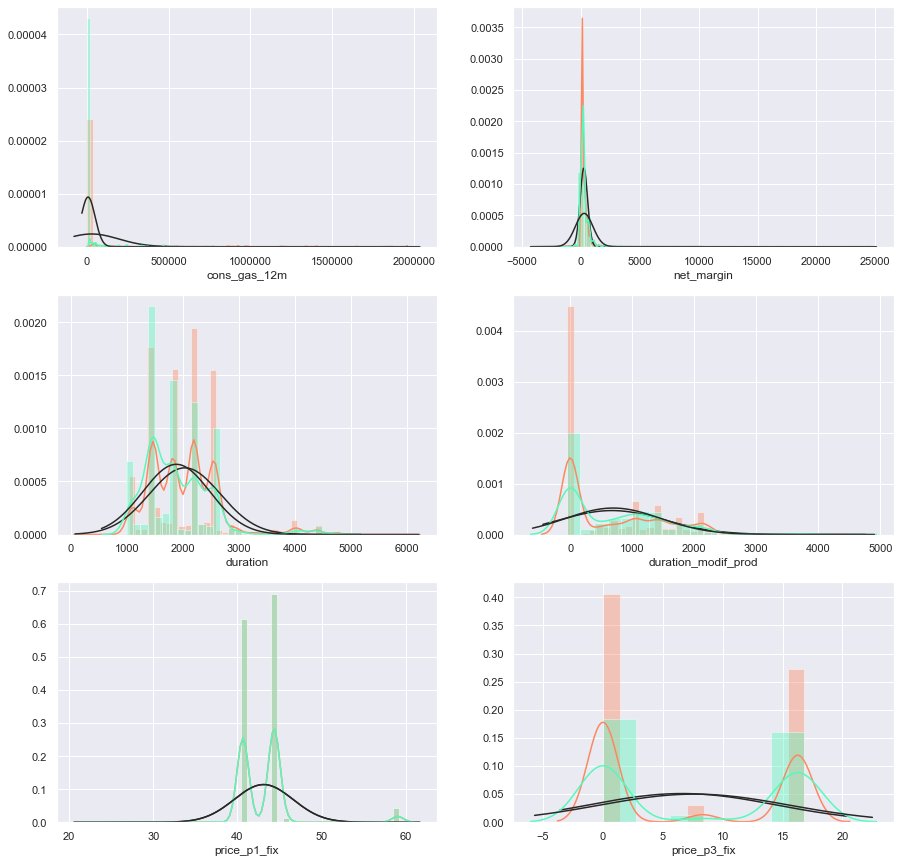

In [240]:
sns.set(style="darkgrid")
fig, ax = plt.subplots(3,2, figsize=(15, 15))

cons_gas_12m0 = df.loc[df.churn==0, 'cons_gas_12m']
cons_gas_12m1 = df.loc[df.churn==1, 'cons_gas_12m']
net_margin0 = df.loc[df.churn==0, 'net_margin']
net_margin1 = df.loc[df.churn==1, 'net_margin']
duration0 = df.loc[df.churn==0, 'duration']
duration1 = df.loc[df.churn==1, 'duration']
duration_modif_prod0 = df.loc[df.churn==0, 'duration_modif_prod']
duration_modif_prod1 = df.loc[df.churn==1, 'duration_modif_prod']
price_p3_fix0 = df.loc[df.churn==0, 'price_p3_fix']
price_p3_fix1 = df.loc[df.churn==1, 'price_p3_fix']
price_p1_fix0 = df.loc[df.churn==1, 'price_p1_fix']
price_p1_fix1 = df.loc[df.churn==1, 'price_p1_fix']

plt.subplot(3,2,1)
sns.distplot(cons_gas_12m0, fit=norm, color='#FB8861')
sns.distplot(cons_gas_12m1, fit=norm, color='#56F9BB')

plt.subplot(3,2,2)
sns.distplot(net_margin0, fit=norm, color='#FB8861')
sns.distplot(net_margin1, fit=norm, color='#56F9BB')

plt.subplot(3,2,3)
sns.distplot(duration0, fit=norm, color='#FB8861')
sns.distplot(duration1, fit=norm, color='#56F9BB')

plt.subplot(3,2,4)
sns.distplot(duration_modif_prod0, fit=norm, color='#FB8861')
sns.distplot(duration_modif_prod1, fit=norm, color='#56F9BB')

plt.subplot(3,2,5)
sns.distplot(price_p1_fix0, fit=norm, color='#FB8861')
sns.distplot(price_p1_fix1, fit=norm, color='#56F9BB')

plt.subplot(3,2,6)
sns.distplot(price_p3_fix0, fit=norm, color='#FB8861')
sns.distplot(price_p3_fix1, fit=norm, color='#56F9BB')

- We can see that variables are not identically distributed and we cannot assume certain distribution.
- Thus, it is better to use non-parametric models, which do not employ the maximum likelihood function.

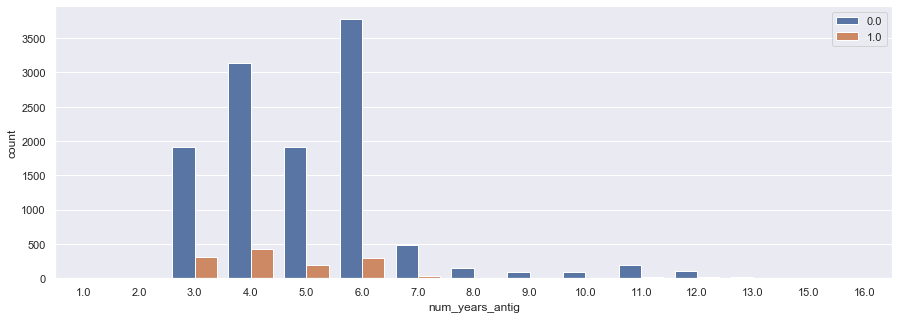

In [55]:
ax = plt.figure(figsize=(15,5))
g = sns.countplot(data=df, x='num_years_antig', hue= 'churn')
plt.legend(loc='upper right')

- 'num_years_antig' = 4 has relatively high churn. <br>


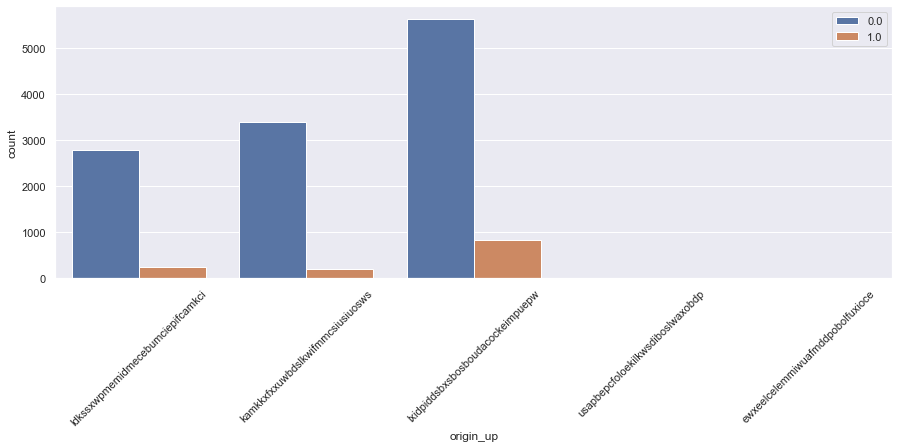

In [58]:
ax = plt.figure(figsize=(15,5))
g = sns.countplot(data=df, x='origin_up', hue= 'churn')
plt.xticks(rotation=45)
plt.legend(loc='upper right')

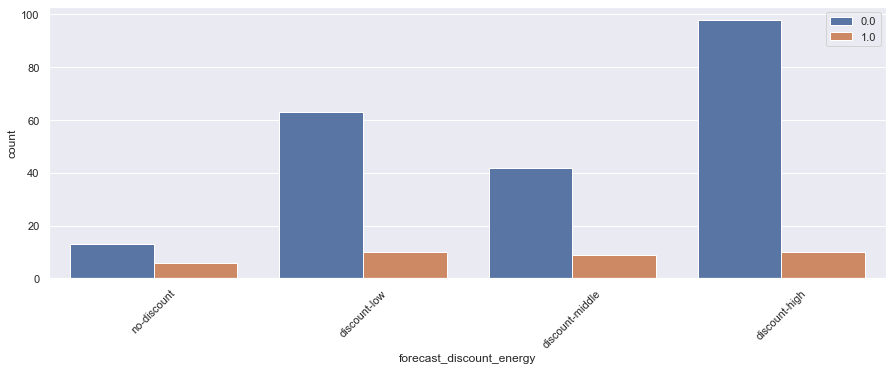

In [237]:
# Create custom interval
interval = (0, 19, 25, 28, 30)
cut = ['no-discount', 'discount-low', 'discount-middle', 'discount-high']
df["forecast_discount_energy"] = pd.cut(df.forecast_discount_energy, interval, labels=cut)

ax = plt.figure(figsize=(15,5))
g = sns.countplot(data=df, x='forecast_discount_energy', hue= 'churn')
plt.xticks(rotation=45)
plt.legend(loc='upper right')

In [18]:
df.groupby(['channel_sales','churn']).count()[['id']].rename(columns = {"id": "count"})

count
channel_sales                    churn       
No                               0.0     3102
                                 1.0      244
epumfxlbckeskwekxbiuasklxalciiuu 0.0        3
ewpakwlliwisiwduibdlfmalxowmwpci 0.0      691
                                 1.0       68
fixdbufsefwooaasfcxdxadsiekoceaa 0.0        2
foosdfpfkusacimwkcsosbicdxkicaua 0.0     5342
                                 1.0      768
lmkebamcaaclubfxadlmueccxoimlema 0.0     1751
                                 1.0      101
sddiedcslfslkckwlfkdpoeeailfpeds 0.0       11
usilxuppasemubllopkaafesmlibmsdf 0.0      965
                                 1.0      109

- Customers came from 'foosdfpfkusacimwkcsosbicdxkicaua' have relatively high churn rate while customers came from 'lmkebamcaaclubfxadlmueccxoimlema' have relatively low churn rate. <br>

## Encode categorical variables

### Feature Hashing for 'activity_new' and OneHot for the rest

In [37]:
fh = FeatureHasher(input_type='string')
f = df[['activity_new']]
h = fh.transform(f)

h=h.toarray()
h=h.transpose()

h=pd.DataFrame(h, columns=['activity_new'])
df.drop(['id','activity_new'], axis=1, inplace=True)

df.reset_index()
h.reset_index()
df.merge(h,how='inner', left_index=True, right_index=True)

df = pd.get_dummies(df, drop_first=True)
df.head()

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_p1,forecast_price_energy_p2,forecast_price_pow_p1,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,pow_max,price_p2_var,price_p3_var,price_p1_fix,price_p2_fix,price_p3_fix,churn,duration,duration_modif_prod,duration_renewal,channel_sales_epumfxlbckeskwekxbiuasklxalciiuu,channel_sales_ewpakwlliwisiwduibdlfmalxowmwpci,channel_sales_fixdbufsefwooaasfcxdxadsiekoceaa,channel_sales_foosdfpfkusacimwkcsosbicdxkicaua,channel_sales_lmkebamcaaclubfxadlmueccxoimlema,channel_sales_sddiedcslfslkckwlfkdpoeeailfpeds,channel_sales_usilxuppasemubllopkaafesmlibmsdf,has_gas_t,origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_up_ldkssxwpmemidmecebumciepifcamkci,origin_up_lxidpiddsbxsbosboudacockeimpuepw,origin_up_usapbepcfoloekilkwsdiboslwaxobdp
0,309275.0,0.0,10025.0,26520.30,10025.0,0.0,359.29,0.095919,0.088347,58.995952,831.8,-41.76,-41.76,1.0,1732.36,3.0,180.0,0.092115,0.067241,58.956502,36.356887,8.337051,0.0,1459.0,0.0,1097.0,0,0,0,0,1,0,0,0,0,1,0,0
2,4660.0,0.0,0.0,189.95,0.0,0.0,16.27,0.145711,0.000000,44.311378,0.0,16.38,16.38,1.0,18.89,6.0,13.8,0.000000,0.000000,44.315416,0.000000,0.000000,0.0,2564.0,0.0,2200.0,0,0,0,0,0,0,0,0,1,0,0,0


## Check correlations

In [14]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

In [15]:
df[df.columns[0:]].corr()['churn'][:]

cons_12m                                         -0.056972
cons_gas_12m                                     -0.040943
cons_last_month                                  -0.053060
forecast_cons_12m                                 0.005346
forecast_cons_year                               -0.005631
forecast_discount_energy                          0.012365
forecast_meter_rent_12m                           0.021772
forecast_price_energy_p1                         -0.010058
forecast_price_energy_p2                          0.016677
forecast_price_pow_p1                            -0.003183
imp_cons                                         -0.004733
margin_gross_pow_ele                              0.078406
margin_net_pow_ele                                0.078419
nb_prod_act                                      -0.019713
net_margin                                        0.019399
num_years_antig                                  -0.074471
pow_max                                           0.0041

## Omit the columns which have more than 0.7 or less than -0.7 corralation

In [16]:
corr = df.corr()
omit1 = []
omit2 = []
for i in range(corr.shape[0]):
    for j in range(i):
        colname = corr.columns[i]
        rowname = corr.index[j]
        if (corr.iloc[i, j] >= 0.7) or (corr.iloc[i, j] <= -0.7):
            omit1.append(colname)
            omit2.append(rowname)

In [17]:
omit = omit1 + omit2
set(omit)

{'cons_12m',
 'cons_last_month',
 'duration',
 'duration_renewal',
 'forecast_cons_12m',
 'forecast_cons_year',
 'forecast_meter_rent_12m',
 'forecast_price_energy_p1',
 'forecast_price_energy_p2',
 'forecast_price_pow_p1',
 'imp_cons',
 'margin_gross_pow_ele',
 'margin_net_pow_ele',
 'net_margin',
 'num_years_antig',
 'price_p1_fix',
 'price_p2_fix',
 'price_p2_var',
 'price_p3_fix',
 'price_p3_var'}

In [18]:
corr_df = df[['churn','cons_12m','cons_last_month','duration','duration_renewal','forecast_cons_12m','forecast_cons_year',
 'forecast_meter_rent_12m','forecast_price_energy_p1','forecast_price_energy_p2','forecast_price_pow_p1','imp_cons','margin_gross_pow_ele',
 'margin_net_pow_ele','net_margin','num_years_antig','price_p1_fix','price_p2_fix','price_p2_var','price_p3_fix','price_p3_var']]

cols = list(corr_df)
cols.insert(0, cols.pop(cols.index('churn')))
corr_df = corr_df.ix[:, cols]

/Users/naitochieri/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  import sys
/Users/naitochieri/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:822: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  retval = getattr(retval, self.name)._getitem_axis(key, axis=i)


### Check separately the correlation of those omitted variable to drop the one which are less corralated to 'churn' 

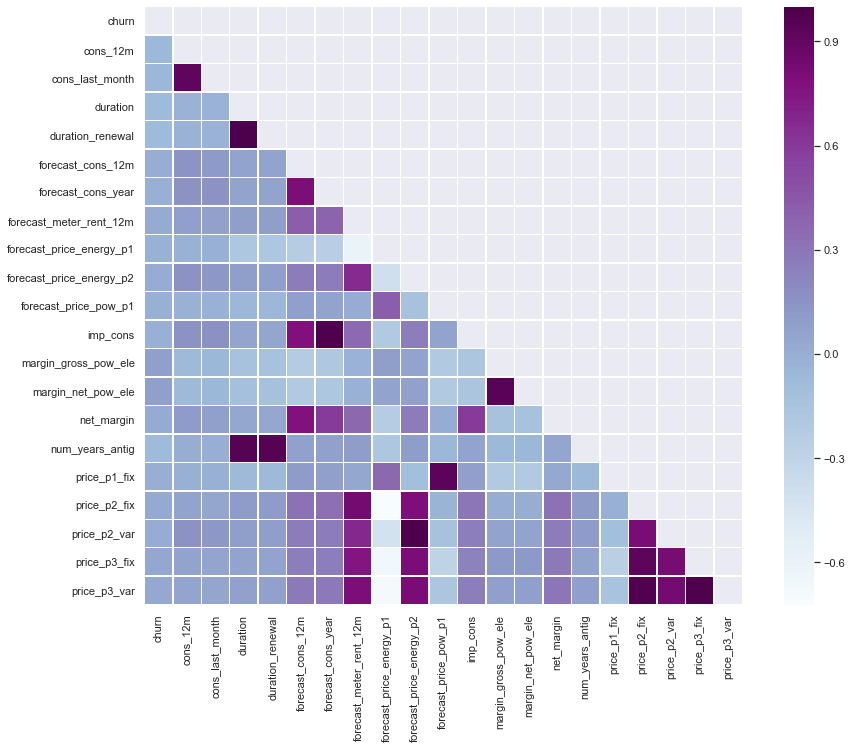

In [19]:
corr_corr = corr_df.corr()

mask = np.zeros_like(corr_corr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize = (15, 11))

sns.heatmap(corr_corr, mask = mask, square = True, linewidths = .5, ax = ax, cmap = "BuPu")      
plt.show()

In [20]:
corr_df[corr_df.columns[0:]].corr()['churn'][:]

churn                       1.000000
cons_12m                   -0.056972
cons_last_month            -0.053060
duration                   -0.071341
duration_renewal           -0.070759
forecast_cons_12m           0.005346
forecast_cons_year         -0.005631
forecast_meter_rent_12m     0.021772
forecast_price_energy_p1   -0.010058
forecast_price_energy_p2    0.016677
forecast_price_pow_p1      -0.003183
imp_cons                   -0.004733
margin_gross_pow_ele        0.078406
margin_net_pow_ele          0.078419
net_margin                  0.019399
num_years_antig            -0.074471
price_p1_fix               -0.002260
price_p2_fix                0.029620
price_p2_var                0.017065
price_p3_fix                0.038701
price_p3_var                0.035481
Name: churn, dtype: float64

In [21]:
# Drop the columns that are less correlated to churn
df_dropped = df
df_dropped = df.drop(['cons_last_month','duration_renewal','forecast_cons_12m','imp_cons','margin_gross_pow_ele','duration',
    'forecast_price_energy_p1','forecast_price_energy_p2','price_p2_var','price_p2_fix','price_p3_var'], axis=1)

In [119]:
model = ols("churn ~ cons_12m + cons_gas_12m + forecast_cons_year + forecast_discount_energy + forecast_meter_rent_12m +forecast_price_pow_p1 + margin_net_pow_ele + nb_prod_act +net_margin + num_years_antig + pow_max + price_p1_fix +price_p3_fix + duration_modif_prod + channel_sales_epumfxlbckeskwekxbiuasklxalciiuu +channel_sales_ewpakwlliwisiwduibdlfmalxowmwpci +channel_sales_fixdbufsefwooaasfcxdxadsiekoceaa +channel_sales_foosdfpfkusacimwkcsosbicdxkicaua +channel_sales_lmkebamcaaclubfxadlmueccxoimlema +channel_sales_sddiedcslfslkckwlfkdpoeeailfpeds +channel_sales_usilxuppasemubllopkaafesmlibmsdf + has_gas_t +origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws +origin_up_ldkssxwpmemidmecebumciepifcamkci +origin_up_lxidpiddsbxsbosboudacockeimpuepw +origin_up_usapbepcfoloekilkwsdiboslwaxobdp", data=df_dropped)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  churn   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     12.38
Date:                Sat, 18 Apr 2020   Prob (F-statistic):           4.38e-52
Time:                        12:53:57   Log-Likelihood:                -2557.7
No. Observations:               13158   AIC:                             5169.
Df Residuals:                   13131   BIC:                             5372.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
==================================================================================================================
                                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
Intercept                                          0.0190      0.046      0.416      0.677      -0.071       0.109
cons_12m                                       -1.266e-08   4.57e-09     -2.773      0.006   -2.16e-08   -3.71e-09
cons_gas_12m                                   -2.809e-08   2.09e-08     -1.342      0.180   -6.91e-08    1.29e-08
forecast_cons_year                             -8.041e-08   7.21e-07     -0.111      0.911   -1.49e-06    1.33e-06
forecast_discount_energy                          -0.0015      0.001     -2.012      0.044      -0.003   -3.78e-05
forecast_meter_rent_12m                        -1.499e-06   6.38e-05     -0.023      0.981      -0.000       0.000
forecast_price_pow_p1                              0.0008      0.001      0.538      0.590      -0.002       0.004
margin_net_pow_ele                                 0.0012      0.000      8.595      0.000       0.001       0.001
nb_prod_act                                        0.0016      0.002      0.888      0.375      -0.002       0.005
net_margin                                       2.86e-05   8.76e-06      3.264      0.001    1.14e-05    4.58e-05
num_years_antig                                   -0.0094      0.002     -4.775      0.000      -0.013      -0.006
pow_max                                           -0.0003      0.000     -1.790      0.073      -0.001    2.84e-05
price_p1_fix                                       0.0006      0.001      0.432      0.666      -0.002       0.003
price_p3_fix                                       0.0013      0.001      2.208      0.027       0.000       0.002
duration_modif_prod                             5.041e-06   3.19e-06      1.582      0.114   -1.21e-06    1.13e-05
channel_sales_epumfxlbckeskwekxbiuasklxalciiuu    -0.1417      0.170     -0.833      0.405      -0.475       0.192
channel_sales_ewpakwlliwisiwduibdlfmalxowmwpci    -0.0127      0.013     -0.998      0.319      -0.038       0.012
channel_sales_fixdbufsefwooaasfcxdxadsiekoceaa    -0.0858      0.208     -0.412      0.680      -0.494       0.322
channel_sales_foosdfpfkusacimwkcsosbicdxkicaua     0.0087      0.008      1.048      0.295      -0.008       0.025
channel_sales_lmkebamcaaclubfxadlmueccxoimlema    -0.0219      0.009     -2.353      0.019      -0.040      -0.004
channel_sales_sddiedcslfslkckwlfkdpoeeailfpeds    -0.1179      0.089     -1.321      0.186      -0.293       0.057
channel_sales_usilxuppasemubllopkaafesmlibmsdf    -0.0065      0.012     -0.558      0.577      -0.029       0.016
has_gas_t                                         -0.0074      0.008     -0.900      0.368      -0.024       0.009
origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws         0.0053      0.035      0.153      0.879   

Only 'cons_12m', 'forecast_discount_energy', 'margin_net_pow_ele', 'net_margin', 'num_years_antig', 'price_p3_fix', 'channel_sales_lmkebamcaaclubfxadlmueccxoimlema' are signigicant.</br>

In [22]:
df_test = df[['churn','cons_12m', 'forecast_discount_energy', 'margin_net_pow_ele', 'net_margin', 'num_years_antig', 'price_p3_fix']]

## Up/Downsample target variable

0.0    11867
1.0     1291
Name: churn, dtype: int64

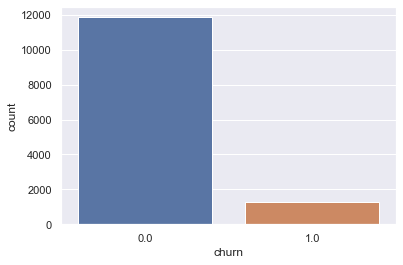

In [182]:
ax = sns.countplot(x="churn", data=df)
df['churn'].value_counts()

In [183]:
churn = df['churn'].values
y = np.array(churn.copy())
X = df.drop(columns=['churn']).values
y = (y > 0)*1

nb_class = len(set(y))
nb_class

# create empty arrays for both classes
id_Train = np.array([None]*nb_class)
id_Test = np.array([None]*nb_class)

for i in range(nb_class):
    id_i = np.where(y==i)[0]
    id_i_train, id_i_test = train_test_split(id_i, test_size=0.3)
    id_Train[i] = id_i_train
    id_Test[i] = id_i_test
    
id_Train = np.concatenate(id_Train)
id_Test = np.concatenate(id_Test)

X_train = X[id_Train]
X_test = X[id_Test]
y_train = y[id_Train]
y_test = y[id_Test]

id_toTrain = np.array([np.where(y_train==i)[0] for i in range(nb_class)])

In [184]:
size_max = [len(id_toTrain[i]) for i in range(nb_class)]
print("Before Resampling", size_max)

blc = 800
for i in range(len(size_max)):
    if size_max[i] > blc:
        size_max[i] = int(blc*(np.log10(size_max[i]/blc)+150))
    else:
        size_max[i] = int(blc/(np.log10(blc/size_max[i])+0.01))
        
print("After Resampling", size_max)

Before Resampling [8306, 903]
After Resampling [120813, 120042]


In [185]:
for i in range(nb_class):
    if len(id_toTrain[i]) > size_max[i]:
        id_toTrain[i], tmp = train_test_split(id_toTrain[i], test_size=1-size_max[i]/len(id_toTrain[i]))
    else:
        id_toTrain[i] = np.concatenate((id_toTrain[i], id_toTrain[i][np.random.randint(len(id_toTrain[i]), size=int(size_max[i]-len(id_toTrain[i])))]))
id_toTrain = np.concatenate(id_toTrain)
X_train = X_train[id_toTrain]
y_train = y_train[id_toTrain]

print(Counter(y_train))

Counter({0: 120813, 1: 120042})


In [186]:
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

X_train.columns = ['cons_12m', 'cons_gas_12m', 'cons_last_month', 'forecast_cons_12m', 'forecast_cons_year', 'forecast_discount_energy','forecast_meter_rent_12m', 'forecast_price_energy_p1',
                   'forecast_price_energy_p2', 'forecast_price_pow_p1', 'imp_cons','margin_gross_pow_ele', 'margin_net_pow_ele', 'nb_prod_act','net_margin', 'num_years_antig', 'pow_max',
                   'price_p2_var', 'price_p3_var', 'price_p1_fix', 'price_p2_fix','price_p3_fix', 'duration', 'duration_modif_prod','duration_renewal', 'channel_sales_epumfxlbckeskwekxbiuasklxalciiuu',
                   'channel_sales_ewpakwlliwisiwduibdlfmalxowmwpci','channel_sales_fixdbufsefwooaasfcxdxadsiekoceaa','channel_sales_foosdfpfkusacimwkcsosbicdxkicaua','channel_sales_lmkebamcaaclubfxadlmueccxoimlema',
                   'channel_sales_sddiedcslfslkckwlfkdpoeeailfpeds','channel_sales_usilxuppasemubllopkaafesmlibmsdf', 'has_gas_t','origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws','origin_up_ldkssxwpmemidmecebumciepifcamkci',
                   'origin_up_lxidpiddsbxsbosboudacockeimpuepw','origin_up_usapbepcfoloekilkwsdiboslwaxobdp']

X_test.columns = ['cons_12m', 'cons_gas_12m', 'cons_last_month', 'forecast_cons_12m', 'forecast_cons_year', 'forecast_discount_energy','forecast_meter_rent_12m', 'forecast_price_energy_p1',
                   'forecast_price_energy_p2', 'forecast_price_pow_p1', 'imp_cons','margin_gross_pow_ele', 'margin_net_pow_ele', 'nb_prod_act','net_margin', 'num_years_antig', 'pow_max',
                   'price_p2_var', 'price_p3_var', 'price_p1_fix', 'price_p2_fix','price_p3_fix', 'duration', 'duration_modif_prod','duration_renewal', 'channel_sales_epumfxlbckeskwekxbiuasklxalciiuu',
                   'channel_sales_ewpakwlliwisiwduibdlfmalxowmwpci','channel_sales_fixdbufsefwooaasfcxdxadsiekoceaa','channel_sales_foosdfpfkusacimwkcsosbicdxkicaua','channel_sales_lmkebamcaaclubfxadlmueccxoimlema',
                   'channel_sales_sddiedcslfslkckwlfkdpoeeailfpeds','channel_sales_usilxuppasemubllopkaafesmlibmsdf', 'has_gas_t','origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws','origin_up_ldkssxwpmemidmecebumciepifcamkci',
                   'origin_up_lxidpiddsbxsbosboudacockeimpuepw','origin_up_usapbepcfoloekilkwsdiboslwaxobdp']

# 2. Modelling

## Random Forest

In [154]:
# Create the parameter grid based on the results of random search 
class_weight = dict({0:1, 1:2})
param_grid = {
    'bootstrap': [True],
    'oob_score' : [True],
    'max_depth': [10,15,20],
    'min_samples_split' : [5],
    'min_samples_leaf' : [5], 
    'n_estimators': [190]}

# Create a based model
rf = RandomForestClassifier(class_weight=class_weight)
# Instantiate the grid search model
grid_search_rf = GridSearchCV(rf, param_grid = param_grid, scoring='roc_auc_ovo_weighted', cv = 3, n_jobs = -1, verbose = 2)

In [155]:
# Fit the grid search to the data
grid_search_rf.fit(X_train, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:  6.6min remaining:  1.9min
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  8.2min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight={0: 1, 1: 2},
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                           

In [156]:
best_grid_rf

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight={0: 1, 1: 2},
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=190,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

In [187]:
best_grid_rf = grid_search_rf.best_estimator_
y_pred_rf = best_grid_rf.predict(X_test)
y_pred_prob_rf = best_grid_rf.predict_proba(X_test)[:,0]

In [188]:
print(color.BOLD + "Accuracy" + color.END, accuracy_score(y_test, y_pred_rf))
print(color.BOLD + "ROC-AUC" + color.END, roc_auc_score(y_test, y_pred_rf))
print(color.BOLD + "Confusion Matrix" + color.END)
print(classification_report(y_test, y_pred_rf))

Accuracy 0.9556849835401368
ROC-AUC 0.8674927696089075
Confusion Matrix
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      3561
           1       0.78      0.76      0.77       388

    accuracy                           0.96      3949
   macro avg       0.88      0.87      0.87      3949
weighted avg       0.96      0.96      0.96      3949



### Feature importance

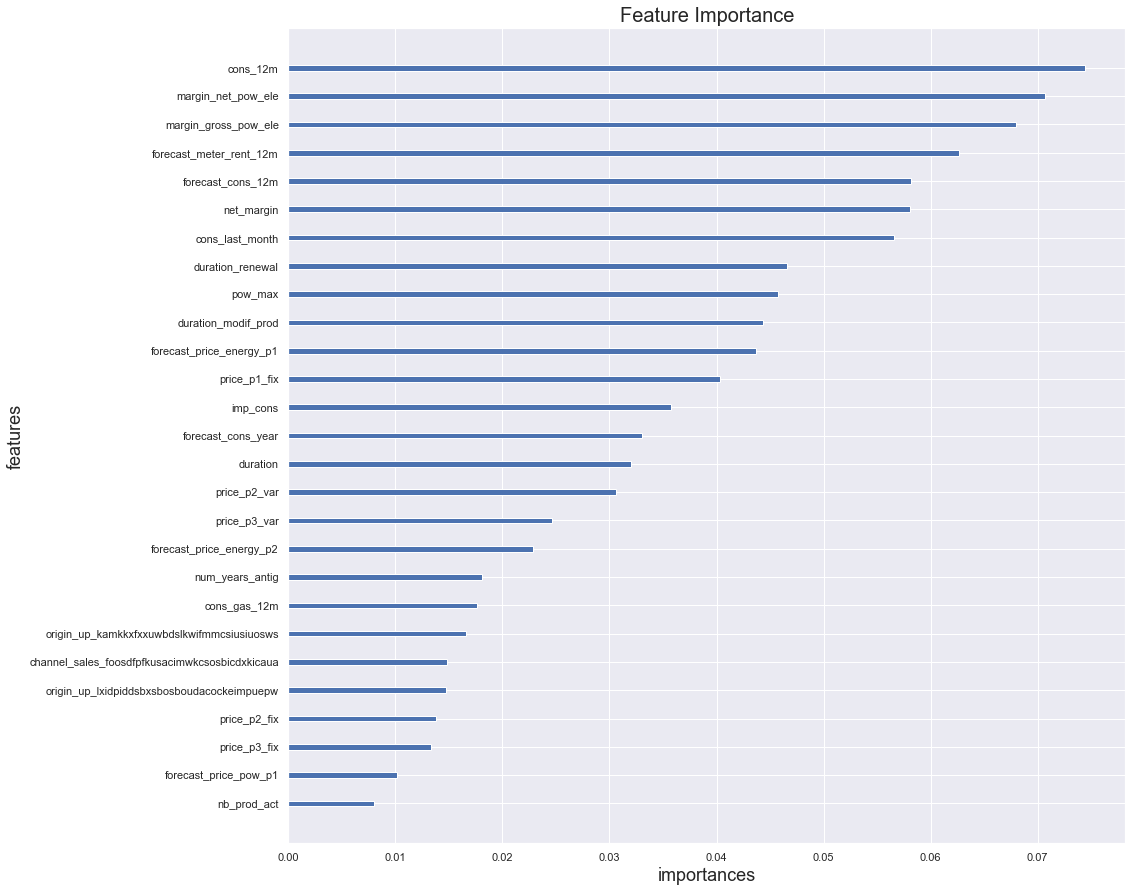

In [190]:
feature_importance(best_grid_rf, X_train.columns)

### Check the optimal weak learners

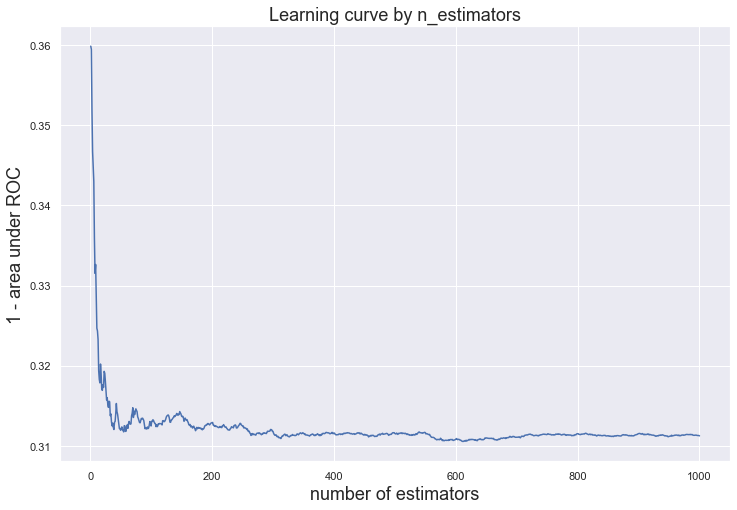

In [1870]:
stop_early(RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 1, 1: 1.4}, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=10,
                       min_samples_split=10,
                       n_estimators=1000, n_jobs=None,
                       random_state=None, verbose=0, warm_start=False), n_min_iterations=30)

- Function shows that after around 190 estimators, it overfits.
- So test the n_estimator around 190

## Xgboost

In [83]:
class_weight = dict({0:1, 1:20})
param_grid = {
    'bootstrap': [True],
    'oob_score' : [True],
    'max_depth': [10],
    'min_samples_split' : [5],
    'min_samples_leaf' : [5], 
    'min_child_weight' : [10],
    'gamma' : [0],
    'n_estimators': [40],
    'scale_pos_weight': [0.1]}

xgb = XGBClassifier(class_weight=class_weight)
grid_search_xgb = GridSearchCV(xgb, param_grid = param_grid, scoring='roc_auc_ovo_weighted', cv = 3, n_jobs = -1, verbose = 2)
grid_search_xgb.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.4min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     class_weight={0: 1, 1: 20},
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha...
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'bootstrap': [True], 'gamma': [0], 'max_depth': [10],
                         'min_child_weight': [10]

In [84]:
grid_search_xgb.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', bootstrap=True,
              class_weight={0: 1, 1: 20}, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=10, min_samples_leaf=5, min_samples_split=5,
              missing=None, n_estimators=40, n_jobs=1, nthread=None,
              objective='binary:logistic', oob_score=True, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [191]:
best_grid_xgb = grid_search_xgb.best_estimator_
y_pred_xgb = best_grid_xgb.predict(X_test)
y_pred_prob_xgb = best_grid_xgb.predict_proba(X_test)[:,0]

In [192]:
print(color.BOLD + "Accuracy" + color.END, accuracy_score(y_test, y_pred_xgb))
print(color.BOLD + "ROC-AUC" + color.END, roc_auc_score(y_test, y_pred_xgb))
print(color.BOLD + "Confusion Matrix" + color.END)
print(classification_report(y_test, y_pred_xgb))

Accuracy 0.9303621169916435
ROC-AUC 0.6479150562942761
Confusion Matrix
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      3561
           1       0.98      0.30      0.46       388

    accuracy                           0.93      3949
   macro avg       0.96      0.65      0.71      3949
weighted avg       0.93      0.93      0.91      3949



### Check the optimal weak learners

In [ ]:
stop_early(XGBClassifier(base_score=0.5, booster='gbtree', bootstrap=True, class_weight={0: 1, 1: 20},
                         colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1, 
                         max_delta_step=0, max_depth=5, min_child_weight=10, min_samples_leaf=5, min_samples_split=5,
                         missing=None, n_estimators=100, n_jobs=1, nthread=None,objective='binary:logistic', oob_score=True)
          ,n_min_iterations=30)

- Rerun the grid search with values where the ROC becames the highest.

### Check the loss and error curve of Train and Test set

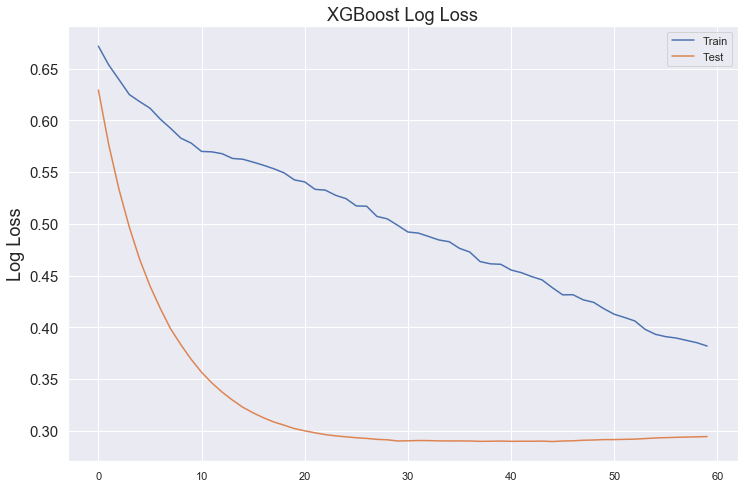

In [674]:
eval_set = [(X_train, y_train), (X_test, y_test)]
best_grid_xgb.fit(X_train, y_train, eval_metric=["error","logloss"], eval_set=eval_set, verbose=False)
results = best_grid_xgb.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss',fontsize=18)
plt.title('XGBoost Log Loss',fontsize=18)
plt.show()

- Logloss is slightly increasing after 40, so reduce the estimator to 40. 

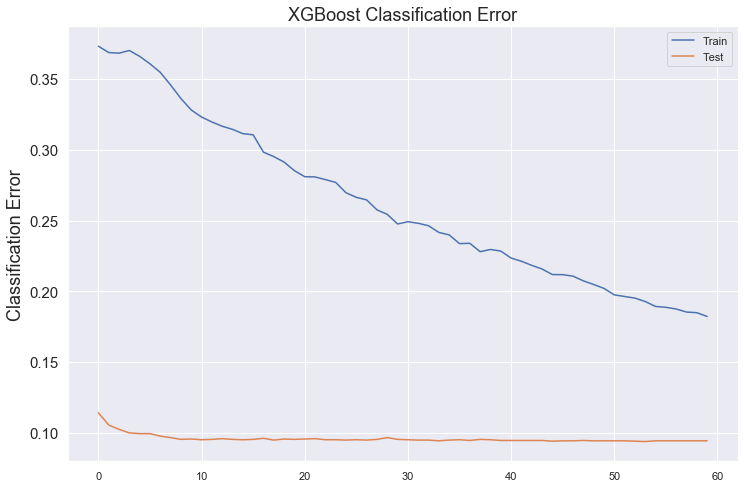

In [676]:
# plot classification error
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('Classification Error',fontsize=18)
plt.title('XGBoost Classification Error',fontsize=18)
plt.show()

### Feature importance

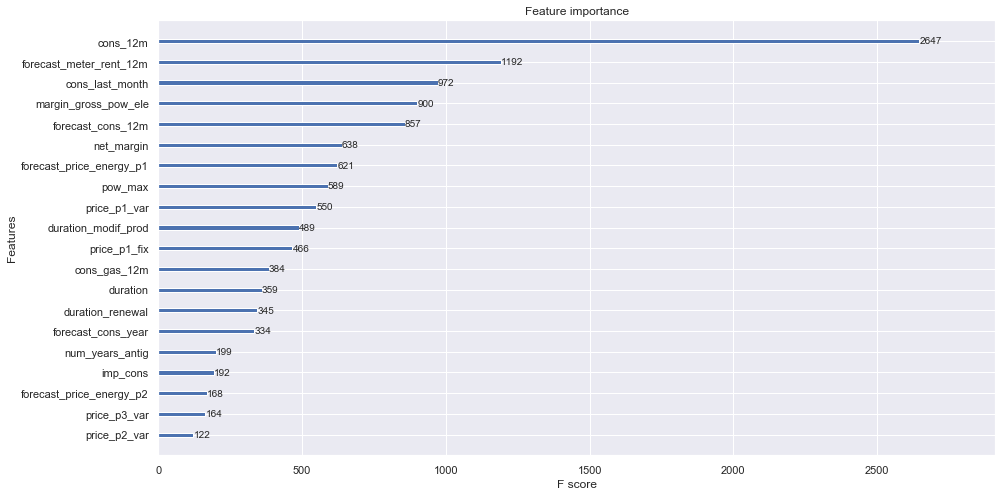

In [1775]:
fig, ax = plt.subplots(figsize=(15, 8))
ax = plot_importance(best_grid_xgb, importance_type = 'weight', max_num_features=20, ax=ax)
plt.rc('font', size=10)
plt.show()

## Gradient Boost

In [97]:
param_grid = {
    'learning_rate' : [0.1],
    'max_features' : [5],
    'max_depth': [5,10],
    'min_samples_split' : [3,5],
    'n_estimators': [101],
}

# Create a based model
gb = GradientBoostingClassifier()
# Instantiate the grid search model
grid_search_gb = GridSearchCV(gb, param_grid = param_grid, scoring='roc_auc_ovo_weighted', cv = 3, n_jobs = -1, verbose = 2)
# Fit the grid search to the data
grid_search_gb.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  5.0min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  5.0min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_c...
                 

In [98]:
grid_search_gb.best_estimator_

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=10,
                           max_features=5, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=3,
                           min_weight_fraction_leaf=0.0, n_estimators=101,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [193]:
best_grid_gb = grid_search_gb.best_estimator_
y_pred_gb = best_grid_gb.predict(X_test)
y_pred_prob_gb = best_grid_gb.predict_proba(X_test)[:,0]

In [194]:
print(color.BOLD + "Accuracy" + color.END, accuracy_score(y_test, y_pred_gb))
print(color.BOLD + "ROC_AUC" + color.END, roc_auc_score(y_test, y_pred_gb))
print(color.BOLD + "Confusion Matrix" + color.END)
print(classification_report(y_test, y_pred_gb))

Accuracy 0.9696125601418081
ROC_AUC 0.8717705700645886
Confusion Matrix
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      3561
           1       0.93      0.75      0.83       388

    accuracy                           0.97      3949
   macro avg       0.95      0.87      0.91      3949
weighted avg       0.97      0.97      0.97      3949



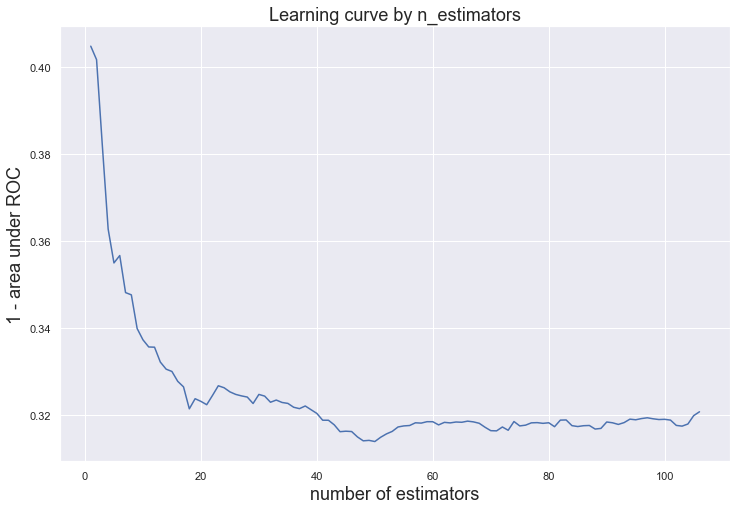

In [1871]:
stop_early(GradientBoostingClassifier(n_estimators=600, learning_rate = 0.1, max_features=5, 
                                      max_depth = 10, random_state = 0), n_min_iterations=30)

### Feature importance

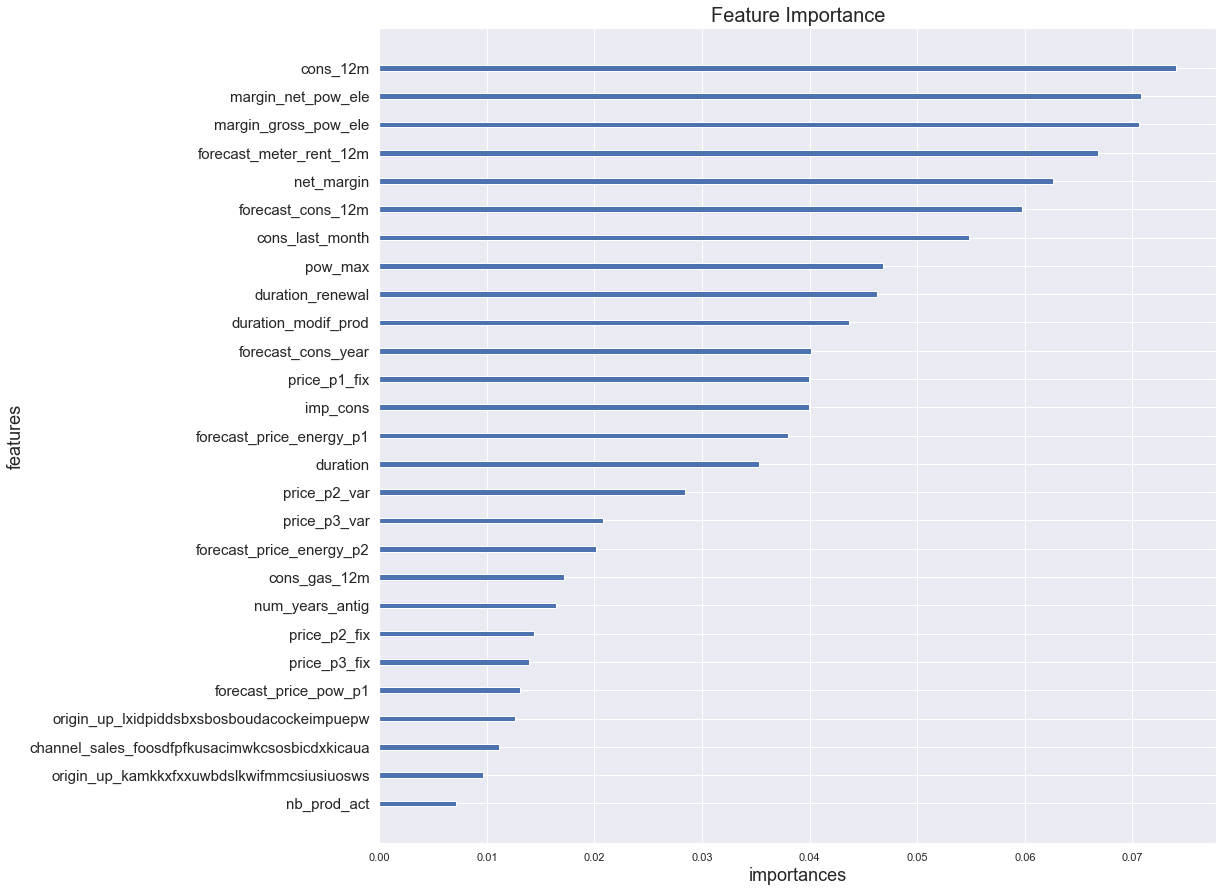

In [195]:
feature_importance(best_grid_gb, X_train.columns)

## Adaboost

In [101]:
param_grid = {
    'n_estimators': [1000],
    'learning_rate' : [1],
}

ab = AdaBoostClassifier()
# Instantiate the grid search model
grid_search_ab = GridSearchCV(ab, param_grid = param_grid, scoring='roc_auc_ovo_weighted', cv = 3, n_jobs = -1, verbose = 2)
# Fit the grid search to the data
grid_search_ab.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed: 11.2min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=None,
                                          learning_rate=1.0, n_estimators=50,
                                          random_state=None),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [1], 'n_estimators': [1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc_ovo_weighted', verbose=2)

In [102]:
grid_search_ab.best_estimator_

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
                   n_estimators=1000, random_state=None)

In [205]:
best_grid_ab = grid_search_ab.best_estimator_
best_grid_ab.fit(X_train, y_train)
y_pred_ab = best_grid_ab.predict(X_test)
y_pred_prob_ab = best_grid_ab.predict_proba(X_test)[:,0]

In [206]:
print(color.BOLD + "Accuracy" + color.END, accuracy_score(y_test, y_pred_ab))
print(color.BOLD + "ROC-AUC" + color.END, roc_auc_score(y_test, y_pred_ab))
print(color.BOLD + "Confusion Matrix" + color.END)
print(classification_report(y_test, y_pred_ab))

Accuracy 0.7449987338566726
ROC-AUC 0.6358466722830667
Confusion Matrix
              precision    recall  f1-score   support

           0       0.93      0.77      0.85      3561
           1       0.19      0.50      0.28       388

    accuracy                           0.74      3949
   macro avg       0.56      0.64      0.56      3949
weighted avg       0.86      0.74      0.79      3949



### Feature importance

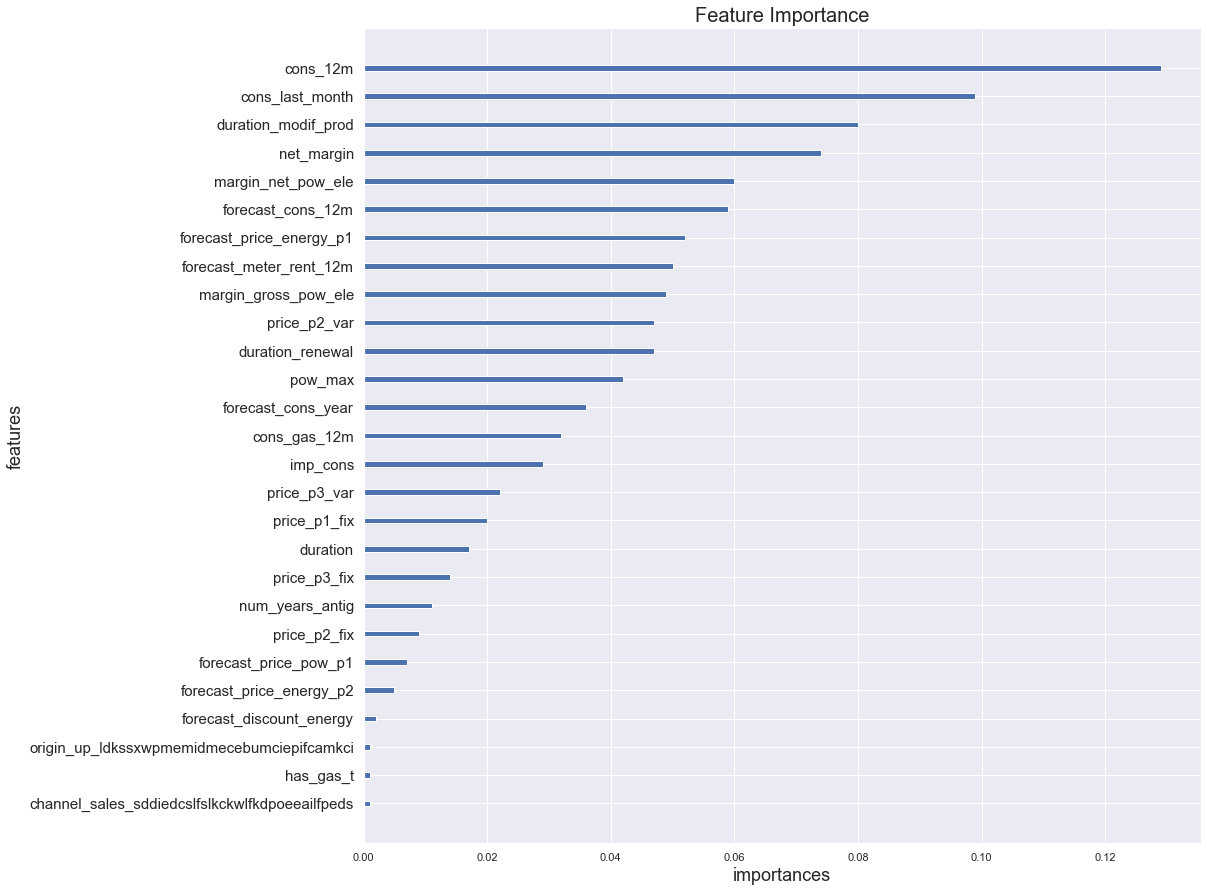

In [250]:
feature_importance(best_grid_ab, X_train.columns)

# 3. Evaluation

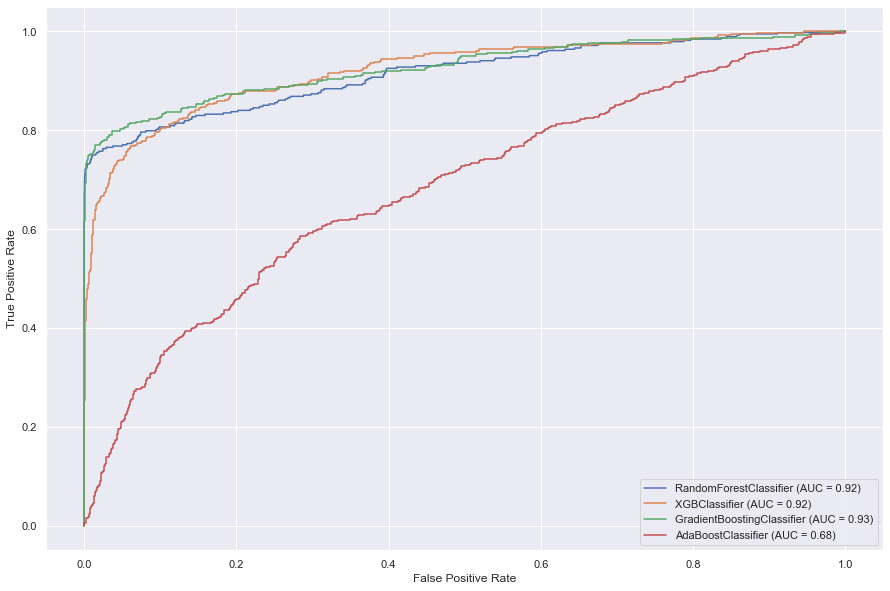

In [208]:
plt.subplots(1, 1, figsize=(15, 10))
ax = plt.subplot(1,1,1)
plot_roc_curve(best_grid_rf, X_test, y_test, ax=ax)
plot_roc_curve(best_grid_xgb, X_test, y_test, ax=ax)
plot_roc_curve(best_grid_gb, X_test, y_test, ax=ax)
plot_roc_curve(best_grid_ab, X_test, y_test, ax=ax)
plt.show()

In [247]:
rf_accuracy = accuracy_score(y_test, y_pred_rf)
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
gb_accuracy = accuracy_score(y_test, y_pred_gb)
ab_accuracy = accuracy_score(y_test, y_pred_ab)

rf_precision = precision_score(y_test, y_pred_rf)
xgb_precision = precision_score(y_test, y_pred_xgb)
gb_precision = precision_score(y_test, y_pred_gb)
ab_precision = precision_score(y_test, y_pred_ab)

rf_recall = recall_score(y_test, y_pred_rf)
xgb_recall = recall_score(y_test, y_pred_xgb)
gb_recall = recall_score(y_test, y_pred_gb)
ab_recall = recall_score(y_test, y_pred_ab)

rf_f1 = f1_score(y_test, y_pred_rf)
xgb_f1 = f1_score(y_test, y_pred_xgb)
gb_f1 = f1_score(y_test, y_pred_gb)
ab_f1 = f1_score(y_test, y_pred_ab)

rf_roc = roc_auc_score(y_test, y_pred_rf)
xgb_roc = roc_auc_score(y_test, y_pred_xgb)
gb_roc = roc_auc_score(y_test, y_pred_gb)
ab_roc = roc_auc_score(y_test, y_pred_ab)


result = {'Model': ['Random Forest', 'XGBoost', 'Gradient Boost', 'Adaboost'],
          'Accuracy' : [rf_accuracy, xgb_accuracy, gb_accuracy, ab_accuracy],
          'Precision' : [rf_precision, xgb_precision, gb_precision, ab_precision],
          'Recall' : [rf_recall, xgb_recall, gb_recall, ab_recall],
          'F1' : [rf_f1, xgb_f1, gb_f1, ab_f1],
          'ROC-AUC' : [rf_roc, xgb_roc, gb_roc, ab_roc]}


result_df = pd.DataFrame(data = result)
result_df

,Model,Accuracy,Precision,Recall,F1,ROC-AUC
0,Random Forest,0.955685,0.784000,0.757732,0.770642,0.867493
1,XGBoost,0.930362,0.982906,0.296392,0.455446,0.647915
2,Gradient Boost,0.969613,0.926752,0.750000,0.829060,0.871771
3,Adaboost,0.744999,0.192651,0.500000,0.278136,0.635847


In [251]:
# Save the best model
filename = 'gb.pkl'
joblib.dump(best_grid_gb, filename, compress = 1)

['gb.pkl']